<a href="https://colab.research.google.com/github/saibaba/FaceRecognitionPCA/blob/master/FaceRecognitionPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA, SVD, and Eigenfaces

This notebook is to study:

* SVD decompose a grayscale image and keep only 85% of energy and visualize
* Do the same with PCA
* Face recognition using eigenfaces

In [3]:
import sys
import os.path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import asarray
from numpy import linalg as LA

In [4]:
#Some common functions
def log10(x):
    return math.log(x) / math.log(10)

vlog10 = np.vectorize(log10)

In [18]:

import shutil
shutil.rmtree('att_faces')


**Get various images to play with in this session.**

In [19]:
!git clone https://github.com/saibaba/att_faces.git

Cloning into 'att_faces'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (416/416), done.
remote: Compressing objects: 100% (411/411), done.
remote: Total 416 (delta 0), reused 416 (delta 0), pack-reused 0
Receiving objects: 100% (416/416), 4.08 MiB | 3.73 MiB/s, done.


Open an image and show it.

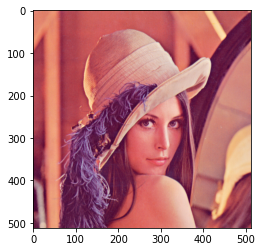

In [6]:
img = Image.open('att_faces/misc/Lenna.png')
plt.imshow(img)
plt.show()


Now, let's do SVD on it.

First, let's convert to gray scale, array.

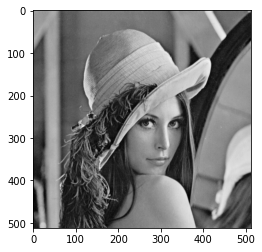

In [7]:

gray = img.convert('L')

plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.show()


In [8]:

data = asarray(gray)
print(type(data))
print(data.shape)


<class 'numpy.ndarray'>
(512, 512)


In [9]:

# if you want to do PCA, center with data -= np.mean(data, axis=0)

u, s, vt = LA.svd(data)

print("Shape of u\n", u.shape)
print("Shape of s\n", s.shape)
print("Shape of vt\n", vt.shape)


Shape of u
 (512, 512)
Shape of s
 (512,)
Shape of vt
 (512, 512)


So, there are 512 singular values. 
Plot singular values.

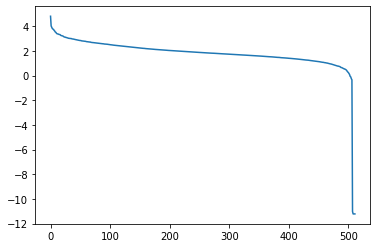

In [12]:
y = vlog10(s)
x = np.arange(0, len(y), 1);


plt.plot(x, y)
plt.show()

Now plot cumulative sum of singular values on log scale. As you see, more and more won't have enough use. First 100 or so are most effective.

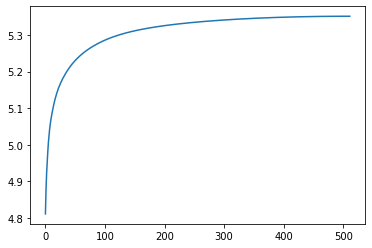

In [13]:
y = vlog10(np.cumsum(s))

x = np.arange(0, len(y), 1);
plt.plot(x, y)

plt.show()

In [10]:
f = LA.norm(data, 'fro')
f2 = f*f
print("Frobenius norm of data: ", f2)
print("Sum of squares first 100 singular values:", sum(np.square(s[:100])))
print("Sum of squares of all singular values:" , sum(np.square(s)))

Frobenius norm of data:  4634117736.0
Sum of squares first 100 singular values: 4629493112.302305
Sum of squares of all singular values: 4634117735.999997


Plot image keeping only first k singular values.


In [11]:

def plot_image(u, s, vt, k):
  reconstimg = np.matrix(u[:, :k]) * np.diag(s[:k]) * np.matrix(vt[:k, :])
  plt.imshow(reconstimg, cmap='gray')
  plt.show()


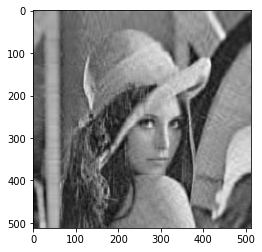

In [15]:
plot_image(u, s, vt, 30)

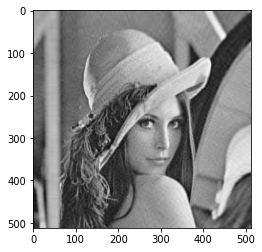

In [16]:
plot_image(u, s, vt, 60)

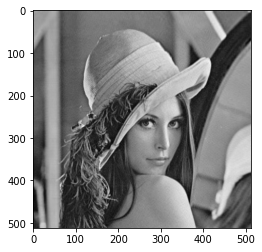

In [17]:
plot_image(u, s, vt, 120)

Now, show image by keeping a percent of energy (instead of k components).

In [16]:
def plot_image_pct(u, s, vt, f2, percent):
  fi = 0
  p = percent*f2
  for i in np.arange(0, len(s)):
      fi += s[i]*s[i]
      if (fi >= p):
          break

  print("Total energy (square of frobenius norm): ", f2)
  k = i+1
  print("Number of components to keep to get ", percent, " energy:", k)

  reconstimg = np.matrix(u[:, :k]) * np.diag(s[:k]) * np.matrix(vt[:k, :])
  plt.imshow(reconstimg, cmap='gray')
  plt.show()

Total energy (square of frobenius norm):  4634117736.0
Number of components to keep to get  0.995  energy: 40


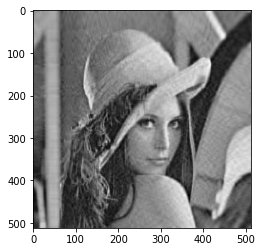

In [17]:
plot_image_pct(u, s, vt, f2, 0.995)

# PCA

Let's do plain PCA.


In [21]:
def cov(X):
    """
    Covariance matrix
    note: specifically for mean-centered data
    note: numpy's `cov` uses N-1 as normalization
    """
    return np.dot(X.T, X) / X.shape[0]

In [24]:
def PCA(X, k = None):
    
    mu = np.mean(X, axis=0)
    X = X - mu
    C = cov(X) #, rowvar = False)
    # since C is symmetric, you can use faster API: eigh
    evals , evecs = LA.eigh(C)

    # sort them
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]

    r = len(evals)
    # keep # of components asked
    if k is None:
      k = r
    evecs = evecs[:, :k]
    return mu, evals, evecs, r, np.dot(X, evecs)

In [54]:
def recover(components, evecs, mu):
    X = np.dot(components, evecs.T)
    r = X.shape[0]
    c = X.shape[1]
    for ir in np.arange(0, r):
        for ic in np.arange(0, c):
            X[ir, ic] += mu[ic]
    return X

In [27]:
# Test code


# https://towardsdatascience.com/the-mathematics-behind-principal-component-analysis-fff2d7f4b643
A = np.array([[90, 60, 90], [90, 90, 30], [60, 60, 60], [60, 60, 90], [30, 30, 30]])

mu, evals, evecs, r, components = PCA(A, 2)
print("mu:\n", mu)
print("evals:\n", evals)
print("evecs\n", evecs)
print("Total comps:\n", r)
recovered = recover(components, evecs, mu)

# Note that eventhough recovered is 5x3 matrix, it is of rank = number of components kept
print(recovered)


mu:
 [66. 60. 60.]
evals:
 [910.06995304 629.11038668  44.81966028]
evecs
 [[-0.65580225  0.3859988 ]
 [-0.4291978   0.51636642]
 [-0.62105769 -0.7644414 ]]
Total comps:
 3
[[83.26424725 67.69359851 91.79572097]
 [90.95476374 88.90946578 29.74546434]
 [62.52556999 57.11528581 59.32669456]
 [65.89209722 53.27002757 88.42919375]
 [27.3633218  33.01162234 30.70292639]]


# Faster PCA

Let's do PCA via a faster mechanism.

In [58]:
def fPCA(X, k = None):
    
    mu = np.mean(X, axis=0)
    X = X - mu
    
    C = X.dot(X.T)
    evals, evecs = LA.eigh(C)
    
    evecs = X.T.dot(evecs)
    norms = LA.norm(evecs, axis=0, keepdims=True)
    evecs = evecs/norms

    # sort them
    idx = norms.flatten().argsort()[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]

    #
    r = len(norms[norms > 0.001])
    
    if k is None:
        k = r
    # keep # of components asked
    evecs_kept = evecs[:, :k]
    evals_kept = evals[:k]
        
    return mu, evals_kept, evecs_kept, r, evals, np.dot(X, evecs_kept)

In [59]:
# Test fPCA

A = np.array([[90, 60, 90], [90, 90, 30], [60, 60, 60], [60, 60, 90], [30, 30, 30]])

mu, evals, evecs, r, all_evals, components = fPCA(A,2 )
print("mean:\n", mu)
print("evals kept :\n", evals)
print("evecs kept :\n", evecs)
print("Total comps:\n", r)
print("all evals :\n", all_evals)

print("Components:\n", components)
recovered = recover(components, evecs, mu)
print(recovered)

mean:
 [66. 60. 60.]
evals kept :
 [4550.34976521 3145.55193338]
evecs kept :
 [[-0.65580225 -0.3859988 ]
 [-0.4291978  -0.51636642]
 [-0.62105769  0.7644414 ]]
Total comps:
 3
all evals :
 [ 4.55034977e+03  3.14555193e+03  2.24098301e+02 -5.60887204e-13
  1.62983272e-13]
Components:
 [[-34.37098481  13.66927088]
 [ -9.98345733 -47.68820559]
 [  3.93481353   2.31599277]
 [-14.69691716  25.24923474]
 [ 55.11654576   6.45370719]]
[[83.26424725 67.69359851 91.79572097]
 [90.95476374 88.90946578 29.74546434]
 [62.52556999 57.11528581 59.32669456]
 [65.89209722 53.27002757 88.42919375]
 [27.3633218  33.01162234 30.70292639]]


# Face Recognition

Now let's put above PCA for some use - see if we can use it for face recognition.

In [61]:
def read_training_data(dataset_path):

  label = 0
  images = []
  labels = []   # note that these are unique labels, not 1-1 mapping with images (probably need to fix this to be 1-1 mapping)
  labels_to_image_file = {}

  for dirname, dirnames, filenames in os.walk(training_data_path):
    for subdirname in sorted(dirnames):
      subdirname_path = os.path.join(dirname, subdirname)

      for subject in sorted(os.listdir(subdirname_path)):
        subject_path = os.path.join(subdirname_path, subject)
        im = Image.open(subject_path)
        imdata = asarray(im)
        images.append(imdata)
        labels.append(label)
        labels_to_image_file.setdefault(label, []).append(subject_path)
        im.close()

      label = label + 1

  return images, labels, labels_to_image_file

In [68]:
# Reads image data files as per the specification and creates a single data matrix where rows are samples
# and columns are attributes/features

class DataSource:
    def __init__(self, training_data_path, test_data_path):
        self.training_images, self.training_labels, self.training_labels_to_image_file = read_training_data(training_data_path)
        print("Number of images: ", len(self.training_images), "\n")
        self.image_height = self.training_images[0].shape[0]
        self.image_width = self.training_images[0].shape[1]
        print("Image height: ", self.image_height, "\n")
        print("Image width: ", self.image_width, "\n")
        print()
    
    def get_training_data_matrix(self):
        train_data = [img.flatten() for img in self.training_images]
        self.L = np.empty(shape=(len(train_data), self.image_height*self.image_width), dtype='float64')

        for i in np.arange(0, len(train_data)):
            self.L[i, :] = train_data[i]

        return self.L
        
    def get_image_data_at_index(self, ndx):
        x = self.L[ndx, :]
        x = x.reshape((self.image_height, self.image_width))
        return x

    def data_from_image(self, image_file):
        img = Image.open(image_file)
        img = img.resize((92, 112))
        test_image = img.convert('L')
        subject = asarray(test_image)
        img.close()
        return subject.flatten()


In [75]:
class FaceRecognizer:
    
    # Compute the K principal components of data matrix L
    def fit(self, L, k):
        self.mu, self.evals, self.evecs, r, self.all_evals, self.components = fPCA(L, k)
        print("number of overall components: " , r)
        self.use_average = False
    
    # Optionally call average to find the matching rows in the principal components for each label and averaging
    # across rows. If this is called, the predict automatically computes the distance between subject and the
    # average of principal components. Otherwise, subject is directly compared with each data row to find the
    # closest match.
    def average(self, labels):
        
        n = np.unique(labels)

        self.labels = n
        w = np.array( [ list([labels[:]==i]) for i in n] )
                
        self.components = np.array([ np.mean(self.components[l.flatten()], axis=0) for l in w ])
        
        self.use_average = True

    # Match given subject/face to one of the existing images. Return the matched indices in the increasing order
    # of distance - so earlier ones are the best ones
    def predict(self, subject):

        subject_avg = subject - self.mu
        subject_avg = subject_avg.reshape((-1, 1))

        subject_components = np.dot(self.evecs.T, subject_avg)

        print(subject_components.shape)

        # in self.components, each row is the "k" principal components of original data rows L, but that are collapsed by averaging based on labels
        # it is of size <collapsed m> times k

        # self.components.T is such that each column is the "k" averaged principal components
        diffs = self.components.T - subject_components

        diffs_norm = LA.norm(diffs, axis=0)

        closest_image_index = diffs_norm.argmin()
        print("Closest image index (rownum) in data matrix L : \n", closest_image_index)
        
        idx = diffs_norm.argsort()

        # the idx are actually, row indexes into L

        ###
        if self.use_average:
            print("Closest 5 image labels: \n", self.labels[idx[:5]])
            return self.labels[idx]
        else:
            print("Closest 5 image indexes: \n", idx[:5])
        ###
        
        return idx

In [104]:
training_data_path = "att_faces/Training"
testing_data_path = "att_faces/Testing"

datasource = DataSource(training_data_path, testing_data_path)
L = datasource.get_training_data_matrix()

recog = FaceRecognizer()
recog.fit(L, 100)
recog.average(datasource.training_labels)


Number of images:  361 

Image height:  112 

Image width:  92 


number of overall components:  360


In [72]:
print(datasource.training_labels_to_image_file)

{0: ['att_faces/Training/Sai/Sai.pgm'], 1: ['att_faces/Training/s1/1.pgm', 'att_faces/Training/s1/2.pgm', 'att_faces/Training/s1/3.pgm', 'att_faces/Training/s1/4.pgm', 'att_faces/Training/s1/5.pgm', 'att_faces/Training/s1/6.pgm', 'att_faces/Training/s1/7.pgm', 'att_faces/Training/s1/8.pgm', 'att_faces/Training/s1/9.pgm'], 2: ['att_faces/Training/s10/1.pgm', 'att_faces/Training/s10/2.pgm', 'att_faces/Training/s10/3.pgm', 'att_faces/Training/s10/4.pgm', 'att_faces/Training/s10/5.pgm', 'att_faces/Training/s10/6.pgm', 'att_faces/Training/s10/7.pgm', 'att_faces/Training/s10/8.pgm', 'att_faces/Training/s10/9.pgm'], 3: ['att_faces/Training/s11/1.pgm', 'att_faces/Training/s11/2.pgm', 'att_faces/Training/s11/3.pgm', 'att_faces/Training/s11/4.pgm', 'att_faces/Training/s11/5.pgm', 'att_faces/Training/s11/6.pgm', 'att_faces/Training/s11/7.pgm', 'att_faces/Training/s11/8.pgm', 'att_faces/Training/s11/9.pgm'], 4: ['att_faces/Training/s12/1.pgm', 'att_faces/Training/s12/2.pgm', 'att_faces/Training/s1

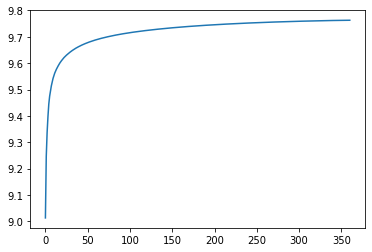

In [110]:
y = vlog10(np.cumsum(recog.all_evals))

x = np.arange(0, len(y), 1);
plt.plot(x, y)

plt.show()

**Try one from training set itself**

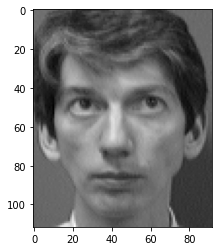

In [106]:

subject_file = "att_faces/misc/29.pgm"
img = Image.open(subject_file)
plt.imshow(img, cmap=plt.get_cmap('gray'))
img.close()

plt.show()


In [107]:

subject = datasource.data_from_image(subject_file)
candidate_indexes = recog.predict(subject)

best_candidate_image_file = datasource.training_labels_to_image_file.get(candidate_indexes[0])[0]

print(best_candidate_image_file)


(100, 1)
Closest image index (rownum) in data matrix L : 
 22
Closest 5 image labels: 
 [22 33 27 15 24]
att_faces/Training/s29/1.pgm


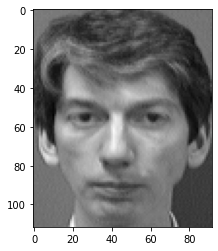

In [108]:
img = Image.open(best_candidate_image_file)
plt.imshow(img, cmap=plt.get_cmap('gray'))
img.close()

plt.show()


**Try one more**

In [111]:
subject_file = "att_faces/Predict/Subjectx.png"

subject = datasource.data_from_image(subject_file)
candidate_indexes = recog.predict(subject)

print(candidate_indexes[:10])

FileNotFoundError: ignored

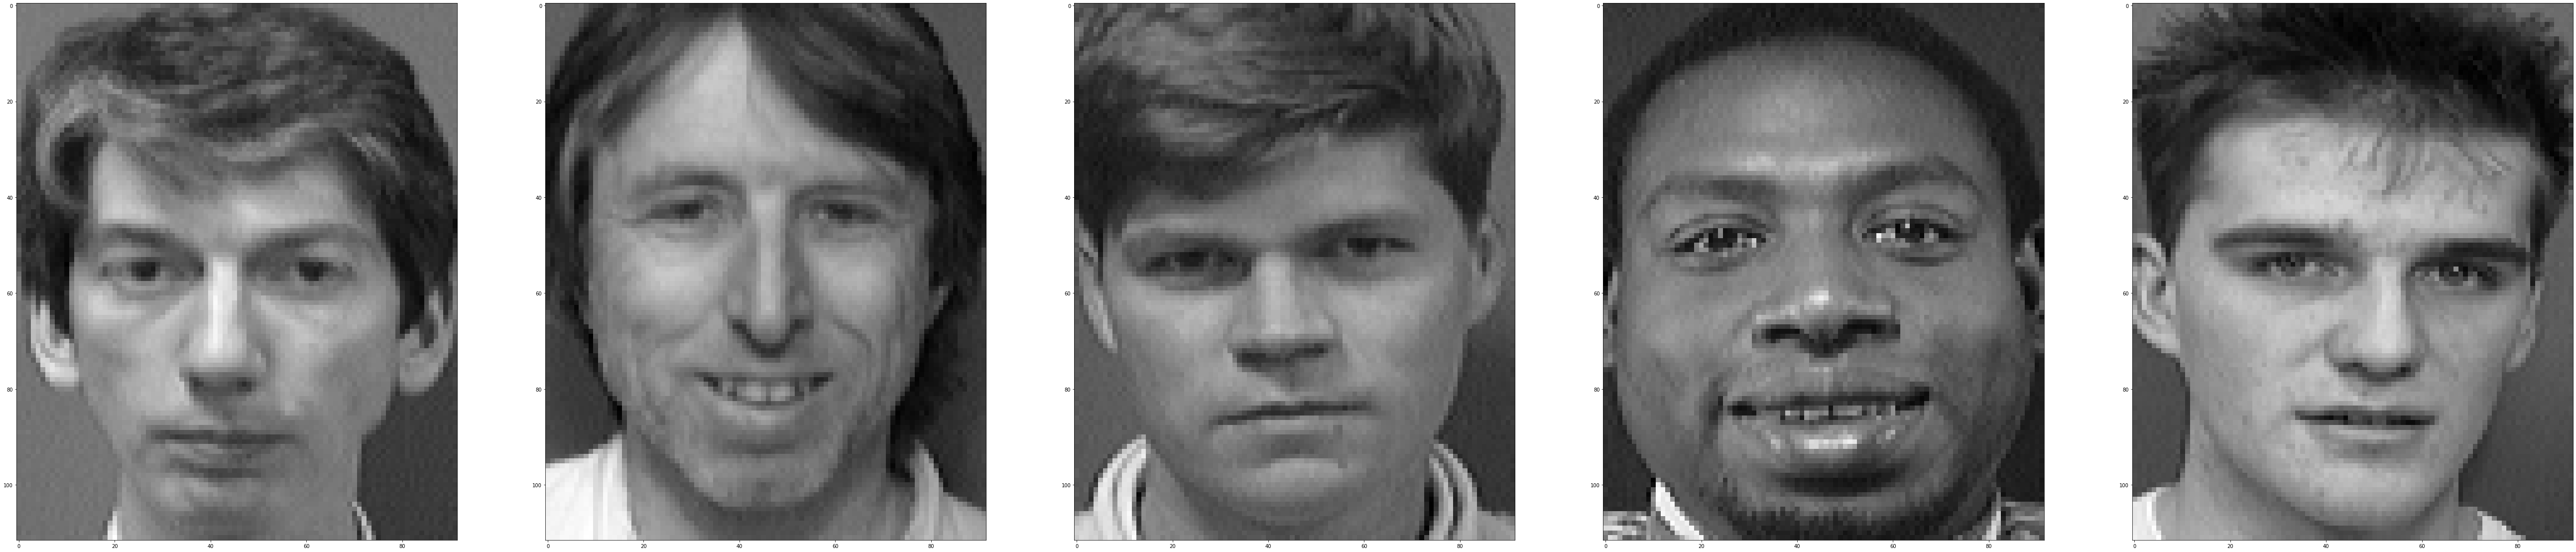

In [113]:

fig, axs = plt.subplots(1, 5, figsize=(datasource.image_width, datasource.image_height))
for i, ndx in enumerate(candidate_indexes[:5]):
  img = Image.open(datasource.training_labels_to_image_file.get(ndx)[0])
  axs[i].imshow(img, cmap=plt.get_cmap('gray'))
  img.close()

plt.show()

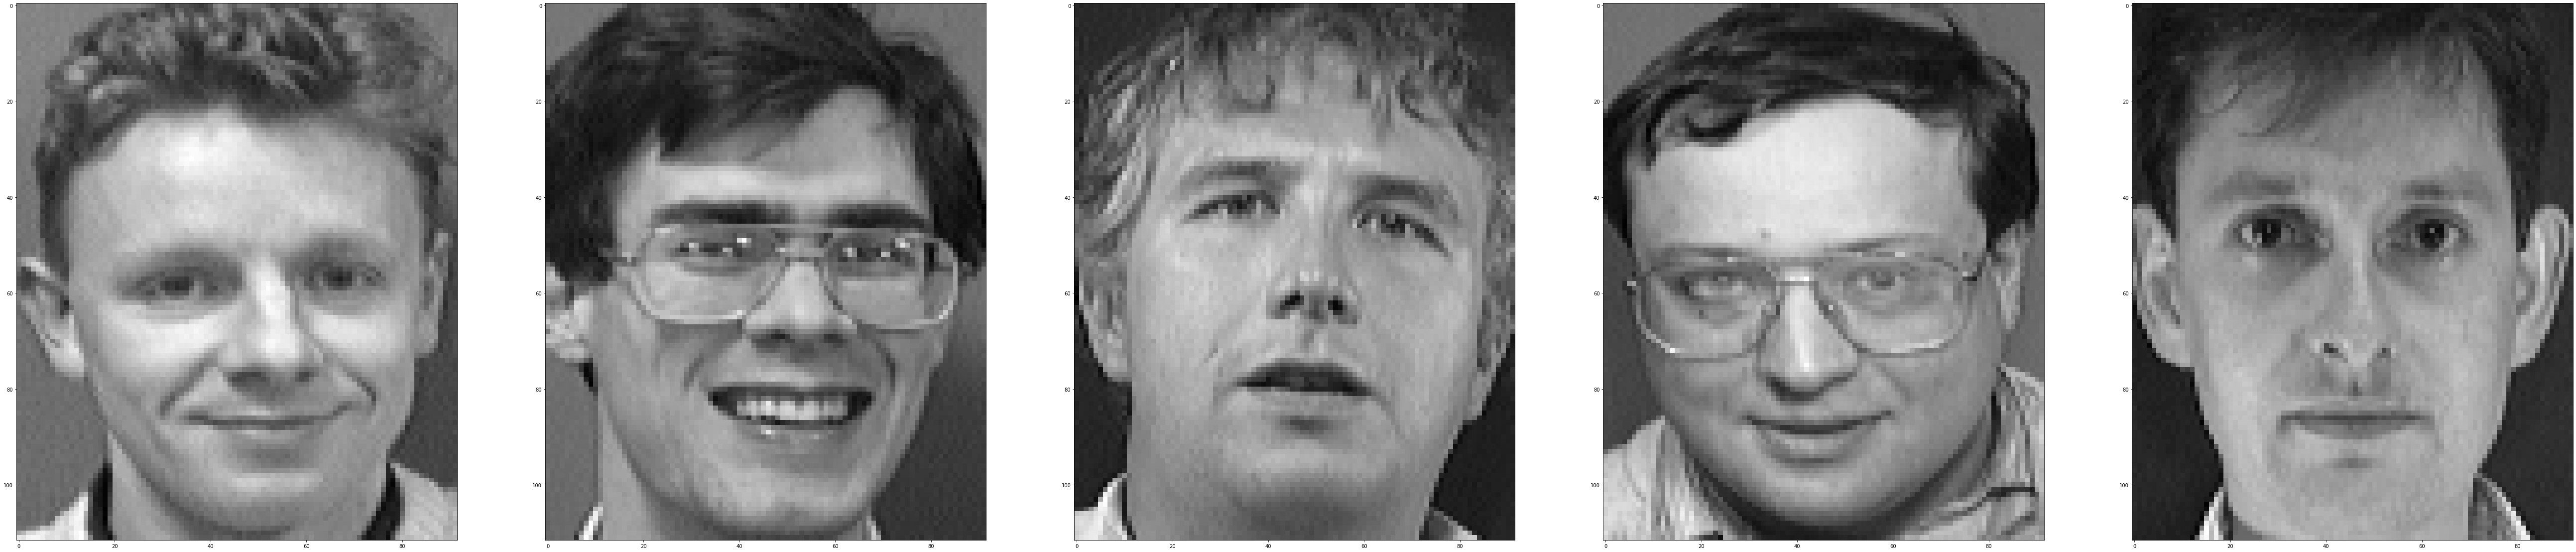

In [114]:

fig, axs = plt.subplots(1, 5, figsize=(datasource.image_width, datasource.image_height))

for i, ndx in enumerate(candidate_indexes[5:10]):
  img = Image.open(datasource.training_labels_to_image_file.get(ndx)[0])
  axs[i].imshow(img, cmap=plt.get_cmap('gray'))
  img.close()

plt.show()

#References

* https://online.stat.psu.edu/stat555/node/94/
* http://docs.opencv.org/modules/contrib/doc/facerec/facerec_tutorial.html
* https://github.com/agyorev/Eigenfaces/blob/master/eigenfaces.py
* https://math.stackexchange.com/questions/92171/what-do-eigenvalues-have-to-do-with-pictures/92187#92187
* https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
* https://github.com/mohamed-elsayed-mohamed/Face-Recognition
* https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/
* https://medium.com/@reubenrochesingh/building-face-detector-using-principal-component-analysis-pca-from-scratch-in-python-1e57369b8fc5
* https://stats.stackexchange.com/questions/235882/pca-in-numpy-and-sklearn-produces-different-results


#Appendix

In [ ]:
# Use this sample to create new training images from given image - it will convert to required form

img = Image.open('/path/to/image.png')
img = img.resize((92, 112))
gray = img.convert('L')

gray.save("/path/to/converted/image.pgm")

plt.imshow(gray, cmap=plt.get_cmap('gray'))


plt.show()

In [ ]:
# Code to sum rows of A based on matching labels (b)


A = np.array([[1,2,3],[4,5,6] ,[7,8,9], [10,11,12], [13,14,15]])
b = np.array([3, 1, 2, 2, 3])
n = np.unique(b)
print(n)
w = np.array( [ list([b[:]==i]) for i in n] )
print(w)
print([ np.mean(A[l.flatten()], axis=0) for l in w ])